### Redes neuronales recurrentes

Sea la siguiente red neuronal recurrente:

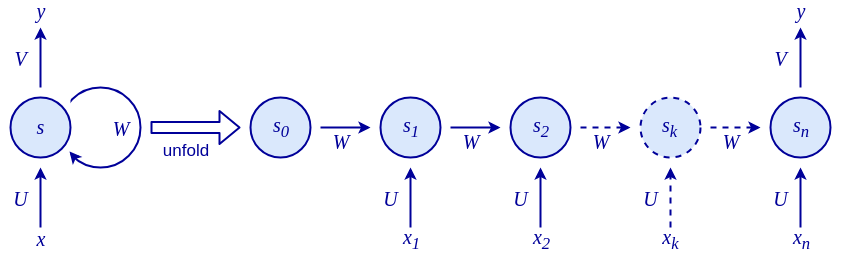

La relación de recurrencia:

$s_t = f(W s_{t -1} + Ux_t)$.

Implementamos una relación de recurrencia.

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def pasos(s, x, U, W):
  return x * U + s * W

En el siguiente bloque de código, realizamos una implementación del paso hacia adelante, que devuelve la activación $s$ para cada paso recurrente y cada muestra en el lote: 


In [ ]:
def forward(x, U, W):
  numero_de_muestras = len(x) # numero de muestras en el minibatch
  longitud_secuencia = len(x[0]) # Longitud de la muestra

  s = np.zeros((numero_de_muestras, longitud_secuencia + 1))

  #Actualizar los estados en la secuencia
  for t in range(0, longitud_secuencia):
    s[:, t +1] = pasos(s[:, t], x[:, t], U, W)  # funcion de pasos

  return s

Ahora que tenemos la función de pérdida y paso hacia adelante, podemos definir cómo se propaga el gradiente hacia atrás. Dado que el RNN desplegado es equivalente a una red de retroalimentación regular, podemos usar la regla de la cadena de retropropagación que presentamos anteriormente.

Debido a que los pesos, W y U, se comparten entre las capas, acumularemos las derivadas de error para cada paso recurrente y al final, actualizaremos los pesos con el valor acumulado. 

Primero, necesitamos obtener el gradiente de la salida, $\mathbf{s}_t$, con respecto a la función de pérdida $\partial E/\partial s$. Una vez que tenemos esta función la propagaremos hacia atrás a través de la pila de actividades que construimos durante el paso hacia adelante. Este pase hacia atrás saca las actividades de la pila para acumular las derivadas de error en cada paso de tiempo. La relación de recurrencia para propagar este gradiente a través de la red se puede escribir de la siguiente manera (regla de la cadena):

$$\frac{\partial E}{\partial s_{t -1}} = \frac{\partial E}{\partial s_t}\frac{\partial s_t}{\partial s_{t -1}} = \frac{\partial E}{\partial s_t}W$$

Aquí $E$ es la función de pérdida.

Los gradientes de los pesos, U y W, se acumulan de la siguiente manera: 

$$\frac{\partial E}{\partial U} = \sum_{t =0}^{n}\frac{\partial E}{\partial s_t}x_t$$

$$\frac{\partial E}{\partial W} = \sum_{t =0}^{n}\frac{\partial E}{\partial s_t}s_{t -1}$$


La siguiente es una implementación del pase hacia atrás: 

In [ ]:
def backward(x, s, y, W):
  longitud_secuencia = len(x[0])
  s_t = s[:, -1]
  gS = 2*(s_t -y)

  gU, gW = 0,  0 # Inicializando gradientes

  # Gradientes acumulados en el paso hacía atrás

  for k in range(longitud_secuencia, 0, -1):
    gU += np.sum(gS *x[:, k -1])
    gW += np.sum(gS * s[:, k -1] )

    gS = gS * W

  return gU, gW

Ahora podemos intentar usar el descenso de gradientes para optimizar nuestra red. Calculamos `gradientes` (usando el error cuadrático medio) con la ayuda de la función `backward` y los usamos para actualizar el valor de los pesos: 

In [ ]:
def entrenamiento(x, y, epocas, tasa_aprendizaje=0.0005):
  pesos = (-2, 0) 
  
  losses = list()
  
  gradientes_u = list()
  
  gradientes_w = list()

  for i in range(epocas):
    s = forward(x, pesos[0], pesos[1])

    # Calcular la perdida

    loss = (y[0] - s[-1, -1]) ** 2
    
    losses.append(loss)

    gradientes = backward(x, s, y, pesos[1])
    gradientes_u.append(gradientes[0])
    gradientes_w.append(gradientes[1])

     # Actualizar cada parametro p, p = p - (gradiente * tasa_aprendizaje)

    pesos = tuple((p - gp * tasa_aprendizaje) for p, gp in zip(pesos, gradientes))

  print(pesos)   

  return np.array(losses), np.array(gradientes_u), np.array(gradientes_w)


A continuación, implementaremos la función `plot_entrenamiento` relacionada, que muestra la función `loss` y los gradientes para cada peso durante las épocas: 

In [ ]:
def plot_entrenamiento(losses, gradientes_u, gradientes_w):
  import matplotlib.pyplot as plt

  # remover los valores nan  y los valores inf
  losses = losses[~np.isnan(losses)][:-1]
  gradientes_u = gradientes_u[~np.isnan(gradientes_u)][:-1]
  gradientes_w = gradientes_w[~np.isnan(gradientes_w)][:-1]

   
  # plot los pesos U y  W
  fig, ax1 = plt.subplots(figsize=(10, 6.8))

  ax1.set_ylim(-3, 600)
  ax1.set_xlabel('epocas')
  ax1.plot(gradientes_u, label='grad U', color='blue', linestyle=':')
  ax1.plot(gradientes_w, label='grad W', color='red', linestyle='--')
  ax1.legend(loc='upper left')

  
  ax2 = ax1.twinx() # 

#Descomentar para dibujar gradientes explosivos 
  ax2.set_ylim(-3, 200)
  ax2.plot(losses, label='Perdida', color='green')
  ax2.tick_params(axis='y', labelcolor='green') 
  ax2.legend(loc='upper right')
 
  fig.tight_layout()

  plt.show()

Finalmente, entrenemos a la red para que aprenda una sola secuencia binaria corta, donde $x$ es la secuencia e $y$ es la etiqueta: 

In [ ]:
x = np.array([[0, 0, 0, 0, 1, 0, 1, 0, 1, 0]])
y = np.array([3])

losses, gradientes_u, gradientes_w = entrenamiento(x, y, epocas=150)
plot_entrenamiento(losses, gradientes_u, gradientes_w)

Podemos tropezar con gradientes explosivos en un NN de avance regular, pero es especialmente pronunciado en las RNN. Para entender por qué, recordemos la regla de la cadena de propagación del gradiente recurrente para los dos pasos de secuencia consecutivos que definimos anteriormente:

$$\frac{\partial E}{\partial s_{t -1}} = \frac{\partial E}{\partial s_t}\frac{\partial s_t}{\partial s_{t -1}} = \frac{\partial E}{\partial s_t}W$$

Dependiendo de la longitud de la secuencia, una RNN desplegada puede ser mucho más profundo en comparación con una red normal. Al mismo tiempo, los pesos, W, de un RNN se comparten en todos los pasos. Por lo tanto, podemos generalizar esta fórmula para calcular el gradiente entre dos pasos no consecutivos de la secuencia. Como W se comparte, la ecuación forma una progresión geométrica: 


$$\frac{\partial s_t}{\partial s_{t -k}} = \frac{\partial s_t}{\partial s_{t -1}}\frac{\partial s_{t-1}}{\partial s_{t -2}} \dots \frac{\partial s_{t-k +1}}{\partial s_{t -k}} = \prod_{j =1}^k\frac{\partial s_{t -j +1}}{\partial s_{t -j}} = W^k$$

Para demostrar el problema de los gradientes que desaparecen, entrenaremos la red usando una secuencia más larga: 

In [ ]:
x = np.array([[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]])
y = np.array([12])

losses, gradientes_u, gradientes_w = entrenamiento(x, y, epocas=150)
plot_entrenamiento(losses, gradientes_u, gradientes_w)

### Ejercicios

1. Implementa el clipping de gradientes en una RNN simple desde cero. Usa el siguiente esqueleto de código para añadir la funcionalidad de clipping a la función backward.

``` 
def backward(x, s, y, W, clip_value=1):
    longitud_secuencia = len(x[0])
    s_t = s[:, -1]
    gS = 2 * (s_t - y)

    gU, gW = 0, 0

    for k in range(longitud_secuencia, 0, -1):
        gU += np.sum(gS * x[:, k -1])
        gW += np.sum(gS * s[:, k -1])
        gS = gS * W

    # Aplica clipping a los gradientes
    gU = np.clip(gU, -clip_value, clip_value)
    gW = np.clip(gW, -clip_value, clip_value)

    return gU, gW


```
Ejecuta el entrenamiento con y sin clipping de gradientes para ver el efecto en la estabilidad y convergencia del entrenamiento. Puedes utilizar secuencias de entrada más largas para ver cómo maneja la RNN los gradientes potencialmente explosivos.

In [ ]:
## Tu respuesta

2. Explora cómo diferentes tasas de aprendizaje afectan el entrenamiento de una RNN. Modifica la tasa de aprendizaje en el script de entrenamiento y observa cómo cambia la convergencia y la aparición de NaNs. Prueba con tasas de aprendizaje muy pequeñas (e.g., 0.00001) y más grandes (e.g., 0.01).

In [ ]:
# Tu respuesta

3.Evalúa cómo el tamaño de la secuencia de entrada afecta el entrenamiento y la estabilidad de la RNN. Crea secuencias de diferentes longitudes y observa si hay una correlación entre la longitud de la secuencia y la aparición de problemas numéricos como NaNs o explosión de gradientes.

In [ ]:
# Tu respuesta

4.Amplía la función de visualización para incluir no solo los gradientes y la pérdida, sino también cómo cambian los pesos U y W con el tiempo durante el entrenamiento. Además, visualiza cómo la salida predicha por la RNN se compara con el valor objetivo y en cada época.

```
import matplotlib.pyplot as plt

def plot_extended(losses, gradientes_u, gradientes_w, pesos_u, pesos_w):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot de gradientes
    axs[0, 0].plot(gradientes_u, label='Grad U', color='blue', linestyle=':')
    axs[0, 0].plot(gradientes_w, label='Grad W', color='red', linestyle='--')
    axs[0, 0].set_title('Gradientes durante el entrenamiento')
    axs[0, 0].legend()

    # Plot de pérdidas
    axs[0, 1].plot(losses, label='Pérdida', color='green')
    axs[0, 1].set_title('Pérdida durante el entrenamiento')
    axs[0, 1].legend()

    # Plot de pesos U
    axs[1, 0].plot(pesos_u, label='Peso U', color='purple')
    axs[1, 0].set_title('Pesos U durante el entrenamiento')
    axs[1, 0].legend()

    # Plot de pesos W
    axs[1, 1].plot(pesos_w, label='Peso W', color='orange')
    axs[1, 1].set_title('Pesos W durante el entrenamiento')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


```

In [ ]:
# Tu respuesta

5.Experimenta añadiendo técnicas de regularización como L2 o Dropout a tu RNN. Observa si la adición de regularización ayuda a mejorar la generalización y a manejar mejor la explosión de gradientes.

In [ ]:
# Tu respuesta

## LSTM y GRU

En esta sección, implementaremos una celda LSTM con PyTorch. Primero, observemos que PyTorch ya tiene una implementación de LSTM, que está disponible en `torch.nn`. LSTM. Sin embargo, nuestro objetivo es comprender cómo funciona la celda LSTM, por lo que implementaremos la propia versión desde cero. La celda será una subclase de `torch.nn.Module` y la usaremos como bloque de construcción para modelos más grandes. 


In [ ]:
import math
import torch
import typing

A continuación, definiremos algunos parámetros de las redes y el proceso de entrenamiento: 

In [ ]:
EPOCAS = 10 
MUESTRAS_ENTRENAMIENTO = 10000  
TAM_BATCH = 16  
MUESTRAS_PRUEBAS = 1000  
LONGITUD_SECUENCIA = 20 
UNIDADES_OCULTAS = 20  

A continuación, implementemos una celda LSTM básica como una subclase de `torch.nn.Module`. El proceso de implementación de la celda solo es un elemento de la secuencia. 

In [ ]:
class celdaLSTM(torch.nn.Module):
  def __init__(self, input_size: int, hidden_size: int):
    super(celdaLSTM, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size

  # Combinamos todas las puertas en una sola multiplicación de matriz 
    self.x_fc = torch.nn.Linear(input_size, 4 * hidden_size)
    self.h_fc = torch.nn.Linear(hidden_size, 4 * hidden_size)

    self.reset_parameters()

  def reset_parameters(self):
    """ Inicializacion de Xavier """
    size = math.sqrt(3.0/self.hidden_size)
    for peso in self.parameters():
      peso.data.uniform_(-size, size)

  def forward(self,
              x_t: torch.Tensor,
              hidden: typing.Tuple[torch.Tensor, torch.Tensor] = (None, None)) \
           -> typing.Tuple[torch.Tensor, torch.Tensor]:
    h_t_1, c_t_1 = hidden # t_1 es equivalente a t-1

    # En caso de entrada de más de 2 dimensiones
    # aplanar el tensor (similar a numpy.reshape) 

    x_t = x_t.view(-1, x_t.size(1))
    h_t_1 = h_t_1.view(-1, h_t_1.size(1))
    c_t_1 = c_t_1.view(-1, c_t_1.size(1))

  #Calculamos las activaciones de todas las puertas simultáneamente 
    puertas = self.x_fc(x_t) + self.h_fc(h_t_1)

  #Dividir la entrada a las 4 puertas separadas 

    i_t, f_t, candidato_c_t, o_t = puertas.chunk(4, 1)

  # Calculamos las activaciones para todas las puertas 
    i_t, f_t, candidato_c_t, o_t = \
       i_t.sigmoid(), f_t.sigmoid(), candidato_c_t.tanh(), o_t.sigmoid()

  # Escogemos un nuevo estado basado en las puertas de entrada y olvido 
    c_t = torch.mul(f_t, c_t_1) + torch.mul(i_t, candidato_c_t)
  
  # Calcular la salida de la celda

    h_t = torch.mul(o_t, c_t.tanh())

    return h_t, c_t

La implementación de celdaLSTM tiene dos limitaciones: 

- Solo cubre un paso de la secuencia.
-  Genera el estado de la celda y el vector de salida de la red. Esta es una tarea de regresión y tenemos un solo valor de salida, pero el estado de la celda y la salida de la red tienen más dimensiones.

Para resolver estos problemas, implementaremos una clase `modeloLSTM` personalizada, que amplía la celdaLSTM. Esta alimenta la instancia de la celdaLSTM con todos los elementos de la secuencia y maneja la transición del estado de la celda y la salida de la red de un elemento de la secuencia al siguiente. 

Una vez que se ha producido la salida final, se alimenta a una capa completamente conectada, que la transforma en un valor escalar único que representa la predicción de la red del número de unidades. 

El siguiente código hace esa implementación.


In [ ]:
class modeloLSTM(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(modeloLSTM, self).__init__()
    self.hidden_size = hidden_size

 # Implementacion de LSTM 
    self.lstm = celdaLSTM(input_size, hidden_size)

 # Capa de salida completamente conectada 
    self.fc = torch.nn.Linear(hidden_size, output_size)

  def forward(self, x):
    c_t = torch.zeros((x.size(0), self.hidden_size)).to(x.device)
    h_t = torch.zeros((x.size(0), self.hidden_size)).to(x.device)

  # Itera sobre todos los elementos de secuencia en todas las secuencias del mini-lote 
    for seq in range(x.size(1)):
      h_t, c_t = self.lstm(x[:, seq, :], (h_t, c_t))

  # Capa de salida final 
    return self.fc(h_t)

Seguiremos el mismo modelo para implementar celdaGRU y modeloGRU respectivamente. Comencemos con la implementación de celdaGRU: 

In [ ]:
class celdaGRU(torch.nn.Module):
  def __init__(self, input_size: int, hidden_size: int):
    super(celdaGRU, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size

    # x a la puerta reset r
    self.x_r_fc = torch.nn.Linear(input_size, hidden_size)
    # x a la puerta de actualizacion z 
    self.x_z_fc = torch.nn.Linear(input_size, hidden_size)

    # x al estado candidato h'(t)
    self.x_h_fc = torch.nn.Linear(input_size, hidden_size)

    # salida de la red o el estado h(t -1) para reestablecer la puerta r
    self.h_r_fc = torch.nn.Linear(hidden_size, hidden_size)

    # salida de la red para actualizar la puerta z al estado de red h(t -1)
    self.h_z_fc = torch.nn.Linear(hidden_size, hidden_size)

    # salida de la red para actualizar la puerta z al estado h(t -1) a través de la puerta de reinicio r
    self.hr_h_fc = torch.nn.Linear(hidden_size, hidden_size)

  def forward(self,
              x_t: torch.Tensor,
              h_t_1: torch.Tensor= None)\
           -> torch.Tensor:
           
    z_t = torch.sigmoid(self.x_z_fc(x_t)+ self.h_z_fc(h_t_1)) # update gate
           
    r_t = torch.sigmoid(self.x_r_fc(x_t)+ self.h_r_fc(h_t_1)) # reset gate
    candidato_h_t = torch.tanh(self.x_h_fc(x_t) + self.hr_h_fc(torch.mul(r_t, h_t_1)))# Estado candidato

     # Celda de salida

    h_t = torch.mul(z_t,h_t_1) + torch.mul(1 -z_t, candidato_h_t)

    return h_t

Continuaremos con la clase modeloGRU para procesar secuencias completas: 

In [ ]:
class modeloGRU(torch.nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(modeloGRU, self).__init__()
    self.hidden_size = hidden_size

    self.gru = celdaGRU(input_size, hidden_size)

    self.fc = torch.nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h_t = torch.zeros((x.size(0), self.hidden_size)).to(x.device)

    for seq in range(x.size(1)):
      h_t = self.gru(x[:, seq, :], h_t)

   # Capa de salida final
   
    return self.fc(h_t)

A continuación, implementaremos la función `genera_dataset`, que genera un total de muestras de secuencias binarias, cada una con una longitud de `longitud_secuencia`. La función devuelve la secuencia y su etiqueta numérica, que indica el número de unos en esa secuencia: 

In [ ]:
def genera_dataset(longitud_secuencia: int, muestras: int):
  secuencias = list()
  etiquetas = list()
  for i in range(muestras):
    a = np.random.randint(longitud_secuencia)/longitud_secuencia
    secuencia = list(np.random.choice(2, longitud_secuencia, p=[a, 1 - a]))
    secuencias.append(secuencia)
    etiquetas.append(int(np.sum(secuencia)))

  secuencias = np.array(secuencias)
  etiquetas = np.array(etiquetas, dtype=np.int8)

  resultado = torch.utils.data.TensorDataset(
      torch.from_numpy(secuencias).float().unsqueeze(-1),
      torch.from_numpy(etiquetas).float())

  return resultado

Continuaremos con la implementación del procedimiento de entrenamiento para modeloLSTM o modeloGRU. Este procedimiento es genérico y no difiere de procedimientos similares para redes MLP. La parte de recurrencia es manejada por la funcionalidad `autodiff` de PyTorch dentro de modeloLSTM y de y modeloGRU: 

In [ ]:
def modelo_entrenamiento(modelo, loss_function, optimizer, data_loader):
  modelo.train()
  
  loss_actual = 0.0
  acc_actual = 0

# iteramos sobre la data de entrenamiento 
  for i, (entradas, etiquetas) in enumerate(data_loader):
    entradas = entradas.to(device)
    etiquetas = etiquetas.to(device)

# Cero a los parametros gradientes
    modelo.zero_grad()
    optimizer.zero_grad()

# Forward
    with torch.set_grad_enabled(True):
      salidas = modelo(entradas).squeeze()
      loss = loss_function(salidas, etiquetas)

# Backward
      loss.backward()
      optimizer.step()

# Estadisticas
    loss_actual += loss.item() * entradas.size(0)
    acc_actual += torch.sum(salidas.round() == etiquetas.data)

  loss_total = loss_actual/len(data_loader.dataset)
  acc_total = acc_actual.double()/len(data_loader.dataset)

  print('Perdida de entrenamiento: {:.4f}; Exactitud: {:.4f}'.format(loss_total, acc_total))

Luego, implementaremos el procedimiento de prueba. Al igual que con el entrenamiento, este es un procedimiento genérico que es similar al de las redes MLP, ya que el procesamiento de la secuencia es manejado internamente por modeloLSTM y modeloGRU: 

In [ ]:
def modelo_prueba(modelo, loss_function, data_loader):
  modelo.eval()

  loss_actual = 0.0
  acc_actual = 0

# iteramos sobre la data de entrenamiento 
  for i, (entradas, etiquetas) in enumerate(data_loader):
    entradas = entradas.to(device)
    etiquetas = etiquetas.to(device)

# Forward
    with torch.set_grad_enabled(False):
      salidas = modelo(entradas).squeeze()
      loss = loss_function(salidas, etiquetas)

# Estadisticas
    loss_actual += loss.item() * entradas.size(0)
    acc_actual += torch.sum(salidas.round() == etiquetas.data)

  loss_total = loss_actual/len(data_loader.dataset)
  acc_total = acc_actual.double()/len(data_loader.dataset)

  print('Perdida de prueba: {:.4f}; Exactitud: {:.4f}'.format(loss_total, acc_total))

  return loss_total, acc_total

Ahora podemos ponerlo todo junto. Comenzaremos instalando el dispositivo, `train_loader` y `test_loader`: 

In [ ]:
# Dispositivo seleccionado
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Genere conjuntos de datos de entrenamiento y prueba 
train = genera_dataset(LONGITUD_SECUENCIA, MUESTRAS_ENTRENAMIENTO)
train_loader = torch.utils.data.DataLoader(train, batch_size=TAM_BATCH, shuffle=True)

test = genera_dataset(LONGITUD_SECUENCIA, MUESTRAS_ENTRENAMIENTO)
test_loader = torch.utils.data.DataLoader(test, batch_size=TAM_BATCH, shuffle=True)

A continuación, creemos una instancia de un modelo LSTM con algunos parámetros:

- Entrada de tamaño 1 para el dígito de la secuencia
- Número de unidades ocultas
- Tamaño de salida del modelo de regresión (número de unidades) 

In [ ]:
modelo = modeloLSTM(input_size=1, hidden_size=UNIDADES_OCULTAS,
                  output_size=1)

#Transferimos el modelo a la  GPU
modelo = modelo.to(device)

A continuación, crearemos una instancia de los componentes del entrenamiento:

In [ ]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(modelo.parameters())

Ejecutaremos el entrenamiento: 

In [ ]:
for epoca in range(EPOCAS):
  print("Epocas{}/{}".format(epoca +1, EPOCAS))

  modelo_entrenamiento(modelo, loss_function, optimizer, train_loader)
  modelo_prueba(modelo, loss_function, test_loader)

**Ejercicio**: Realiza el mismo experimento con `modeloGRU`. 

In [ ]:
modelo = modeloGRU(input_size=1, hidden_size=UNIDADES_OCULTAS,
                  output_size=1)

modelo = modelo.to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(modelo.parameters())
for epoca in range(EPOCAS):
  print("Epocas{}/{}".format(epoca +1, EPOCAS))

  modelo_entrenamiento(modelo, loss_function, optimizer, train_loader)
  modelo_prueba(modelo, loss_function, test_loader)

### Ejercicios

1.  Modifica las clases celdaLSTM y celdaGRU para incluir dropout. PyTorch ofrece torch.nn.Dropout, que puedes añadir a las salidas de las capas antes de pasarlas a la siguiente capa o a la salida final. Experimenta con diferentes tasas de dropout para ver cómo afectan el rendimiento del modelo en el entrenamiento y la validación.

In [ ]:
# Tu respuesta

2. Usa la función genera_dataset para crear datasets con diferentes longitudes de secuencia, por ejemplo, 10, 20, 50 y 100.  Entrena tu modelo LSTM o GRU con estos datasets y compara su rendimiento. Observa si modelos con más unidades ocultas manejan mejor secuencias más largas.

In [ ]:
# Tu respuesta

3.Modifica la función reset_parameters en las clases de celda para experimentar con diferentes métodos de inicialización, como la inicialización ortogonal (torch.nn.init.orthogonal_) o la inicialización normal (torch.nn.init.normal_).  Evalúa cómo cada método afecta la rapidez de convergencia y la estabilidad durante el entrenamiento.

In [ ]:
# Tu respuesta

4.Modifica las clases celdaLSTM y celdaGRU para registrar los valores de las puertas (i.e., puertas de entrada, olvido, salida en LSTM; puertas de actualización y reinicio en GRU) durante el entrenamiento. Visualiza estos valores para diferentes tipos de entradas y observa cómo las puertas reaccionan a cambios en los datos de entrada.

In [ ]:
# Tu respuesta

5.Utiliza un enfoque sistemático para ajustar hiperparámetros como la tasa de aprendizaje, el tamaño del batch, y el número de unidades ocultas. Herramientas como torch.optim.lr_scheduler pueden ser útiles aquí Implementa y utiliza una búsqueda grid o búsqueda aleatoria para encontrar los mejores hiperparámetros para tu modelo.

In [ ]:
# Tu respuesta

6.Elige una tarea específica de modelado, como la predicción de series temporales o el análisis de sentimiento. Implementa y compara los modelos LSTM y GRU en esta tarea. Analiza cuál modelo es más eficiente en términos de tiempo de entrenamiento y recursos, y cuál proporciona mejores resultados.

In [ ]:
# Tu respuesta